In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import copy

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx]['input'], ", ".join(self.data[idx]['user_contacts']), self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
DEBUG = False
if DEBUG:
    train_ds.data = train_ds.data[:128]
    val_ds.data = val_ds.data[:32]

In [6]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=2, shuffle=False)

In [7]:
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2").to(device)
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [8]:
def process_batch(batch, tokenizer):
    encoder_strs = [f'[{b}] {a}: {c}' for a,b,c in zip(batch[0], batch[1], batch[2])]

    return tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [9]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            optimizer.zero_grad()
            loss = model(**proc_batch, labels=proc_batch['input_ids']).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        for batch in tqdm(val_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            loss = model(**proc_batch, labels=proc_batch['input_ids']).loss

            val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

        print(f' Val Loss: {val_loss}')
        print('')

        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, (train_losses, val_losses)

In [10]:
best_model, (train_losses, val_losses) = train(model, tokenizer, train_dl, val_dl, optimizer)
torch.save(best_model, 'intent-slot-gpt2.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.3415590524673462


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.361923336982727

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionError: if w.is_alive():can only test a child process

  File "/opt/con

 Train Loss: 1.158923625946045


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3226292133331299

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.1185040473937988


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3135005235671997

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

 Train Loss: 1.0965535640716553


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.309518575668335

best model: 3
Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.080450415611267


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3040988445281982

best model: 4
Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f31f63cd9e0>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers(): 
can only test a child process
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in: <function _Mult

 Train Loss: 1.0630934238433838


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3017537593841553

best model: 5
Epoch 6:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.049095869064331


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3043303489685059

Epoch 7:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0311729907989502


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3087786436080933

Epoch 8:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0219104290008545


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 1.3145023584365845



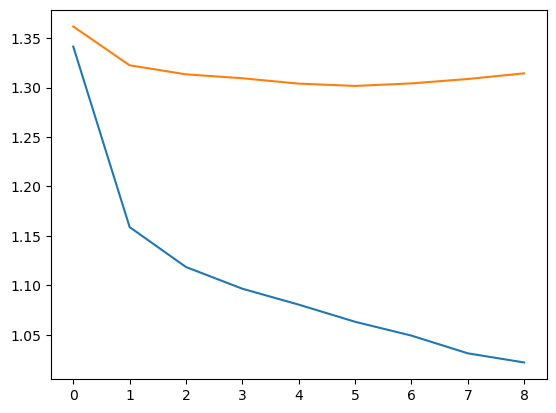

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

In [12]:
def generate(model, tokenizer, ds):

    pred_gens = []
    gold_gens = []
    
    model.eval()
    for eg in tqdm(ds):
        encoder_toks = tokenizer(f'[{eg[0]}] {eg[1]}: \xa0', return_tensors="pt", padding=True, truncation=True).to(device)

        # beam search generations for syntax rather than nucleus sample
        gen = model.generate(
            **encoder_toks,
            num_beams=5,
            max_new_tokens=100,
        )
        
        pred_gens += [tokenizer.decode(gen[0], skip_special_tokens=True).split(': \xa0')[-1]]
        gold_gens += [eg[2]]
    
    return pred_gens, gold_gens

In [13]:
eval_tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [14]:
pred_gens, gold_gens = generate(model, eval_tokenizer, val_ds)

  0%|          | 0/9272 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [15]:
def matches(y1, y2):
    return ("".join(y1.split()) == "".join(y2.split()))

def exact_match_metric(gold, pred):
    cnt_correct = 0
    for i in range(len(gold)):
        if(matches(gold[i], pred[i])):
            
            cnt_correct += 1
    return cnt_correct/len(gold)

In [16]:
exact_match_metric(gold_gens, pred_gens)

0.1693270060396894